# Solving the MNIST Challenge with PyTorch

![MNIST](imgs/01.mninst-intro.png)

### Why MNIST?
- A standard **"Hello World"** dataset for computer vision tasks.
- Simple to understand, yet challenging enough to evaluate the performance of machine learning models.
- Widely used to test and compare new algorithms in machine learning and deep learning.

## Global and imports settings

In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets

# Ensure reproducibility
random_seed = 1
torch.manual_seed(random_seed)

## MNIST Dataset

The MNIST dataset is one of the most well-known benchmarks in the field of machine learning and deep learning. It consists of:
- **70,000 grayscale images** of handwritten digits (0-9).
- Each image is **28x28 pixels**, making it small and computationally efficient.
- **Labels (0 to 9)** corresponding to the digit in the image.

Originally derived from the NIST (National Institute of Standards and Technology) dataset, MNIST was curated and processed to 
simplify the digit recognition task for researchers and developers.

## Getting training dataset

In [2]:
# Load the dataset without transformations
mnist_data_raw = datasets.MNIST(root='./mnist-data-raw', train=True, download=True, transform=None)

mnist_data_raw

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./mnist-data-raw
    Split: Train

## Exploring dataset

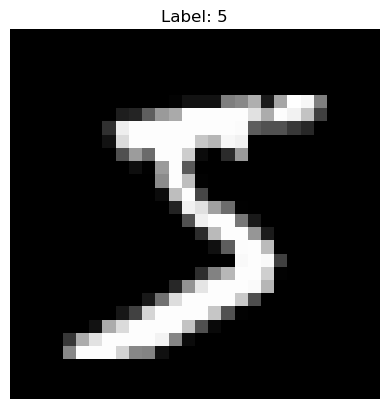

In [3]:
# Fetch one item (an image and its label)
example_image, example_target = mnist_data_raw[0]
example_image, example_target

# Show in grayscale
plt.imshow(example_image, cmap='gray') 
# Display the label as the title
plt.title(f"Label: {example_target}")  
# Hide axes and show image
plt.axis('off') 
plt.show()

## Draw detailed pixel information

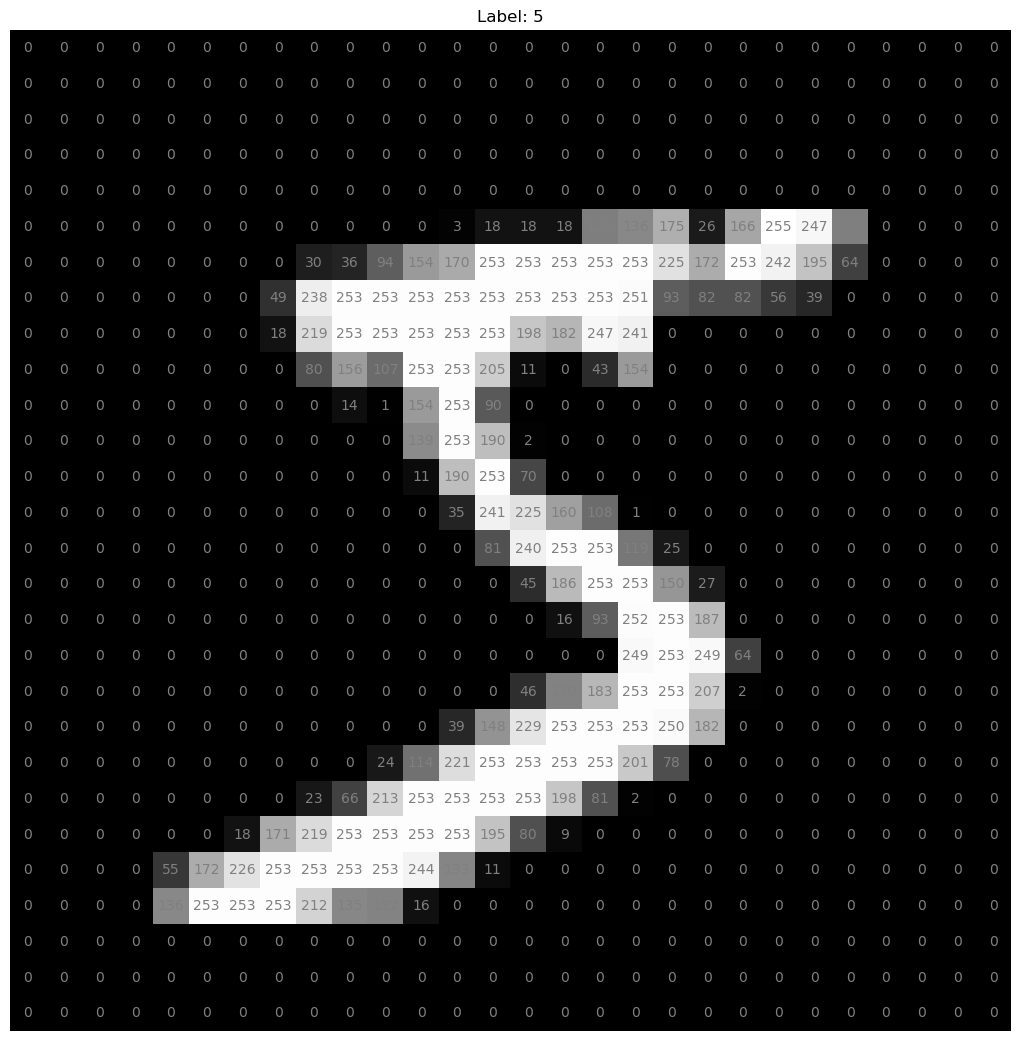

In [4]:
# Convert the PIL image to a NumPy array for pixel access
example_array = np.array(example_image)

# Display the image using matplotlib
# figsize defines the size of the image in pixels.
fig, ax = plt.subplots(figsize=(13, 13))
ax.imshow(example_array, cmap='gray')

# Annotate each pixel with its grayscale value
width, height = example_array.shape
for x in range(width):  # Loop over rows
    for y in range(height):  # Loop over columns
        ax.text(y, x, str(example_array[x, y]), fontsize=10, color='gray', ha='center', va='center')

plt.title(f"Label: {example_target}")
plt.axis('off')  # Hide axes for clarity
plt.show()

## Data preprocessing: normalization

In [5]:
transform_mnist = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                              torchvision.transforms.Normalize((0.1307,), (0.3081,)),
                              ])

### Image Preprocessing with `torchvision.transforms`

- **`torchvision.transforms.ToTensor()`**
  - Converts input images (PIL images or `uint8` NumPy arrays) into PyTorch tensors.
  - Scales pixel intensities from the integer range `[0, 255]` to floating-point values in the range `[0.0, 1.0]`.
  - Ensures compatibility with neural network models, which expect tensor inputs.

- **`torchvision.transforms.Normalize((0.1307,), (0.3081,))`**
  - **Purpose:** Standardizes pixel values to have zero mean and unit variance.
  - Normalization stabilizes training, improves numerical conditioning, and often leads to faster convergence and better model performance.
  - Applies channel-wise normalization using dataset-specific statistics.

- **Normalization Formula**

  The transformation is applied as:

  $$
  \text{normalized\_value} = \frac{\text{original\_value} - \mu}{\sigma}
  $$

  where:
  - $\mu$ is the mean of the dataset
  - $\sigma$ is the standard deviation of the dataset

- **In this configuration:**
  - Mean $\mu = 0.1307$
  - Standard deviation $\sigma = 0.3081$
  - Resulting pixel values are centered around `0`, with most values typically falling within a few standard deviations of the mean.

These preprocessing steps are commonly used for grayscale image datasets such as MNIST and help ensure consistent input distributions across training and evaluation.

In [6]:
batch_size_train = 64
batch_size_test = 1000

# Load the MNIST dataset (training set)
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('mnist-data/', 
                             train=True, 
                             download=True,
                             transform=transform_mnist),
    batch_size=batch_size_train, 
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('mnist-data/', 
                             train=False, 
                             download=True,
                             transform=transform_mnist),
    batch_size=batch_size_test, 
    shuffle=True)

# List all files in the current directory
files = os.listdir('./mnist-data/MNIST/raw')
print(files)

['train-images-idx3-ubyte.gz', 'train-images-idx3-ubyte', 'train-labels-idx1-ubyte.gz', 'train-labels-idx1-ubyte', 't10k-images-idx3-ubyte.gz', 't10k-images-idx3-ubyte', 't10k-labels-idx1-ubyte.gz', 't10k-labels-idx1-ubyte']


| File Name                   | Content            | Purpose                                   |
|-----------------------------|--------------------|-------------------------------------------|
| `train-images-idx3-ubyte`   | Training images    | 60,000 training images (28x28 pixels).   |
| `t10k-images-idx3-ubyte`    | Test images        | 10,000 test images (28x28 pixels).       |
| `train-labels-idx1-ubyte`   | Training labels    | Labels for the 60,000 training images.   |
| `t10k-labels-idx1-ubyte`    | Test labels        | Labels for the 10,000 test images.       |
| `*.gz` files                | Compressed files   | Compressed versions of the above files.  |


## Plot example images

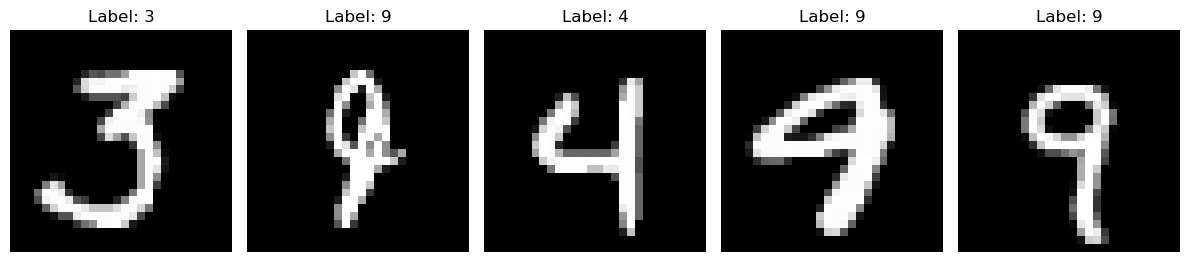

In [7]:
# Fetch one item (an image and its label)
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
fig, axes = plt.subplots(1, 5, figsize=(12, 4))
for i, ax in enumerate(axes):
    ax.imshow(example_data[i][0], cmap='gray')
    ax.set_title(f"Label: {example_targets[i].item()}")
    ax.axis('off')
plt.tight_layout()
plt.show()


In [8]:
example_data.shape

torch.Size([1000, 1, 28, 28])

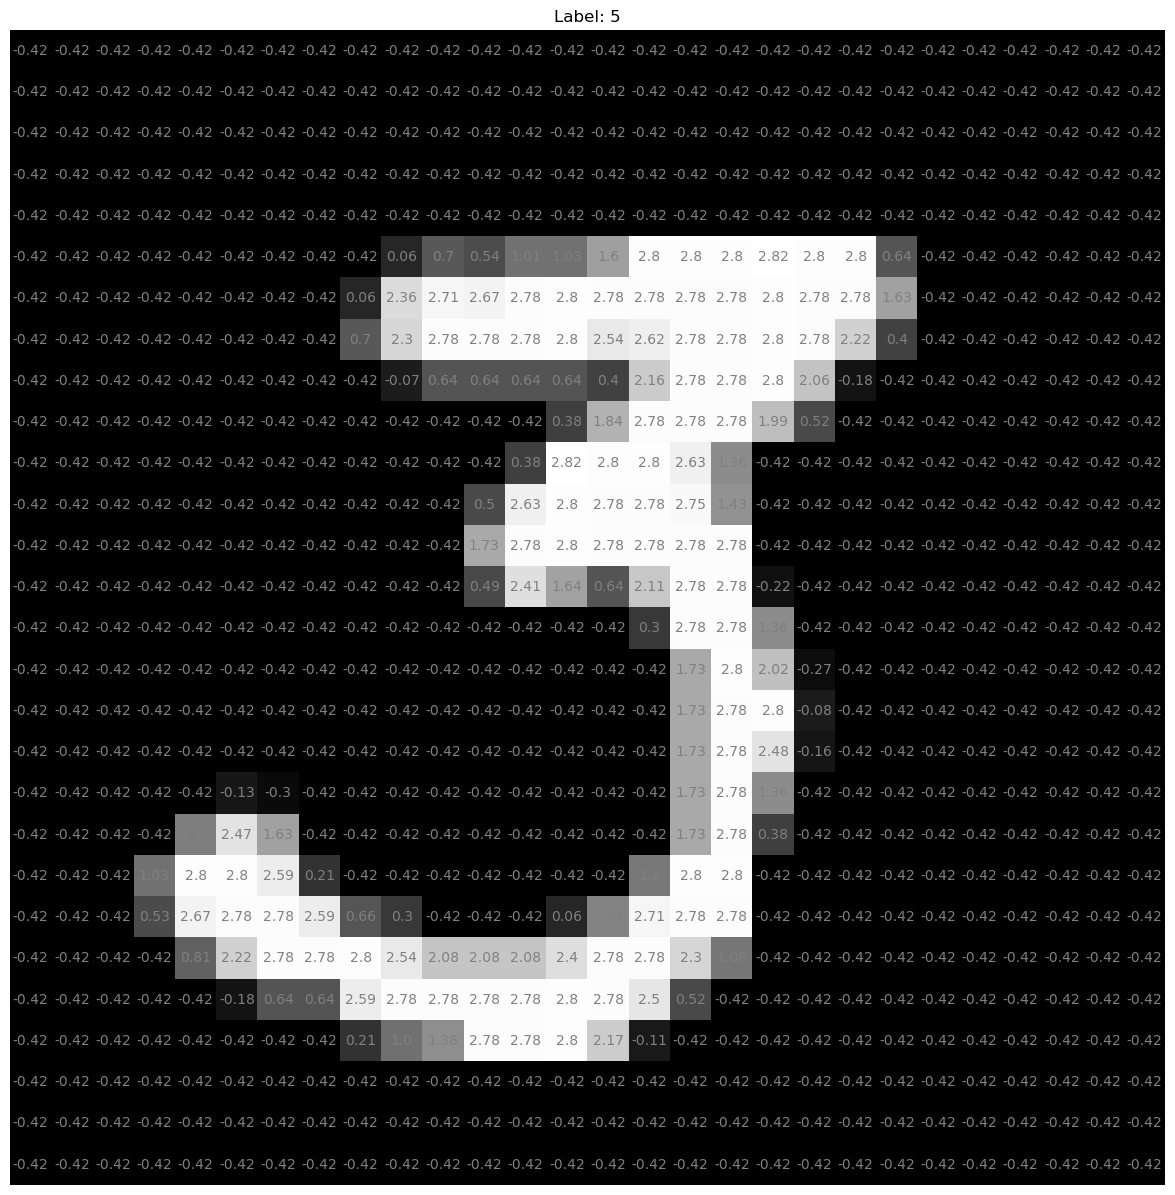

In [9]:
# Convert the PIL image to a NumPy array for pixel access
example_array = example_data[0][0].numpy()

# Display the image using matplotlib
# figsize defines the size of the image in pixels.
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(example_array, cmap='gray')

# Annotate each pixel with its grayscale value
width, height = example_array.shape
for x in range(width):  # Loop over rows
    for y in range(height):  # Loop over columns
        ax.text(y, x, str(round(example_array[x, y], 2)), fontsize=10, color='gray', ha='center', va='center')

plt.title(f"Label: {example_target}")
plt.axis('off')  # Hide axes for clarity
plt.show()

## Convolutional Neuronal Network Design

![CNN Pipeline](imgs/cnn-design.png)

## Building the Network with PyTorch

Now let's go ahead and build our network. We'll use two 2-D convolutional layers followed by two fully-connected (or linear) layers. As activation function we'll choose rectified linear units (ReLUs in short) and as a means of regularization we'll use two dropout layers. 

In [10]:
class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# Explanation of the PyTorch Network

This network, implemented as the class `Net`, is a compact **convolutional neural network (CNN)** designed for image classification tasks such as handwritten digit recognition. Its architecture follows a standard and widely used CNN pattern: convolution → pooling → fully connected layers.

---

## Input and Output

- **Input:**  
  A tensor of shape `[batch_size, 1, H, W]`, representing a batch of grayscale images with height `H` and width `W`.

- **Output:**  
  A tensor of shape `[batch_size, 10]`, containing the **log-probabilities** for each of the 10 target classes.

---

## Model Architecture (`__init__`)

The network is composed of the following layers:

- **Convolutional Layers**
  - `conv1`:  
    - 1 input channel → 10 output channels  
    - 5×5 convolution kernel
  - `conv2`:  
    - 10 input channels → 20 output channels  
    - 5×5 convolution kernel
  - `conv2_drop`:  
    - 2D dropout applied after the second convolution to reduce overfitting

- **Fully Connected Layers**
  - `fc1`:  
    - 320 input features → 50 output features
  - `fc2`:  
    - 50 input features → 10 output features (one per class)

---

## Forward Pass (`forward`)

The forward method defines how data flows through the network:

1. **First Convolution Block**
   - Apply `conv1`
   - Apply ReLU activation
   - Apply 2×2 max pooling

2. **Second Convolution Block**
   - Apply `conv2`
   - Apply 2D dropout
   - Apply ReLU activation
   - Apply 2×2 max pooling

3. **Flattening**
   - Convert the 2D feature maps into a 1D vector of size 320

4. **Fully Connected Layers**
   - Apply `fc1` followed by ReLU
   - Apply dropout during training
   - Apply `fc2` to produce class scores

5. **Output Layer**
   - Apply log-softmax to obtain log-probabilities for each class

---

## Key Components Explained

### Convolutional Layers
- Extract spatial features such as edges and shapes from the input images.
- Deeper layers learn increasingly abstract representations.
- The number of filters increases from 10 to 20 to capture richer features.

### Max Pooling
- Reduces spatial resolution by selecting the maximum value in each 2×2 region.
- Improves computational efficiency and highlights the most important features.

### Dropout
- Randomly disables a fraction of activations during training.
- Helps prevent overfitting and improves generalization.
- Automatically disabled during evaluation (`model.eval()`).

### Fully Connected Layers
- Combine learned features into a compact representation.
- Produce final class scores used for classification.

### Activation Functions
- **ReLU:**  
  - Introduces non-linearity  
  - Computationally efficient  
  - Helps avoid vanishing gradients  
  - Encourages sparse activations
- **Log-Softmax:**  
  - Converts class scores into log-probabilities  
  - Commonly used with negative log-likelihood loss

## Summary

- This CNN is **small, efficient, and well-suited for datasets like MNIST**.
- Convolution and pooling layers extract and refine spatial features.
- Dropout improves robustness and reduces overfitting.
- Fully connected layers and log-softmax provide a standard and effective classification head.

This architecture serves as a clear and practical introduction to convolutional neural networks in PyTorch.

## Building Training Pipeline

In [11]:
log_interval = 1000

# hyper parameters for the training
learning_rate = 0.01
momentum = 0.5
n_epochs = 10

network = MNISTNet()
optimizer = optim.SGD(network.parameters(), 
                      lr=learning_rate,
                      momentum=momentum)

* **learning_rate = 0.01**
  - Defines the learning rate for the optimizer, controlling the step size for weight updates during training.
* **momentum = 0.5**
  - Specifies the momentum parameter to smooth updates by considering the past gradients, helping to avoid local minima and accelerate convergence.
* **network = Net()** Creates an instance of the neural network model, Net. This should be a class defined elsewhere in the code that specifies the network architecture.

### Key Takeaway
This setup is essential for training the Net model, with SGD optimizing the weights based on gradient updates and momentum improving convergence efficiency.

## Training step

In [12]:
train_losses = []
train_counter = []

def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    # Compute the negative log likelihood loss.
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
      
    # diagnostic trace
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), 'model.pth')
      torch.save(optimizer.state_dict(), 'optimizer.pth')

### Description 

- **optimizer.zero_grad()**: Resets gradients from the previous step.
- **output = network(data)**: Passes input data through the network to get predictions.
- **loss = F.nll_loss(output, target)**: Computes the negative log-likelihood loss. It specifically expects log-probabilities as input, such as those produced by a Log Softmax layer.
- **loss.backward()**: Calculates gradients for backpropagation.
- **optimizer.step()**: Updates the model parameters using the optimizer

## Test step

In [14]:
test_losses = []
test_counter = []
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, reduction='sum').item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))


### Description 
- **output = network(data)**: Feeds input data into the model for predictions.
- **test_loss += F.nll_loss(...)**: Computes and accumulates the negative log-likelihood loss for the entire dataset (using sum over all samples).
- **pred = output.data.max(1, keepdim=True)[1]**: Determines the class with the highest probability for each sample.
- **correct += pred.eq(target.data.view_as(pred)).sum()**: Counts correctly predicted labels.

# Understanding Gradient Descent Through Simulation

This document provides an intuitive, step-by-step explanation of **gradient descent** using a minimal example.  
The goal is to build strong intuition for how optimization works before extending the ideas to larger neural networks.

---

## 1. Problem Overview

The task is to fit a very simple model:

- **Model:** a single neuron with a linear relationship  
  $$
  \hat{y} = w \cdot x
  $$

- **Input:**  
  $$
  x = 1.0
  $$

- **Target:**  
  $$
  y = 3.0
  $$

- **Objective:**  
  Learn the weight $$ w $$ such that the prediction matches the target value.

---

## 2. Loss Function

The quality of a prediction is measured using **Mean Squared Error (MSE)**:

$$
L(w) = (w \cdot x - y)^2
$$

This loss function penalizes large prediction errors and produces a smooth, convex curve, making it ideal for illustrating gradient descent.

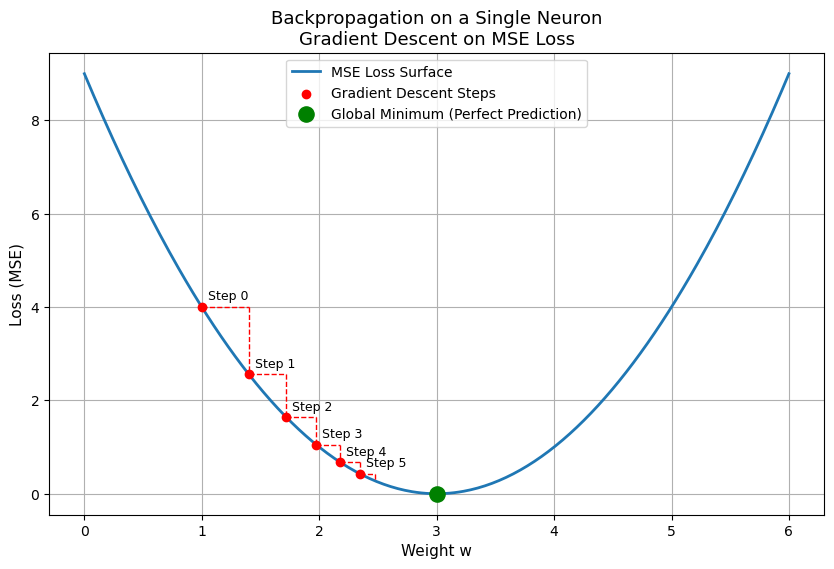

In [13]:
# Input and target
x = 1.0
true_value = 3.0

# Initial weight
w = 1.0
learning_rate = 0.1

# Track path
weights = [w]
losses = []

# Weight space for full loss curve
w_space = np.linspace(0, 6, 300)
loss_curve = (w_space * x - true_value) ** 2

# Training loop (true backprop)
for _ in range(6):
    # Forward pass
    prediction = w * x
    loss = (prediction - true_value) ** 2
    losses.append(loss)

    # Backpropagation
    gradient = 2 * (prediction - true_value) * x
    w -= learning_rate * gradient
    weights.append(w)

# Plot loss surface
plt.figure(figsize=(10, 6))
plt.plot(w_space, loss_curve, label="MSE Loss Surface", linewidth=2)

# Plot optimization steps
for i in range(len(weights) - 1):
    # Horizontal step: parameter update
    plt.plot(
        [weights[i], weights[i+1]],
        [losses[i], losses[i]],
        'r--',
        linewidth=1
    )

    # Vertical step: loss change
    new_loss = (weights[i+1] * x - true_value) ** 2
    plt.plot(
        [weights[i+1], weights[i+1]],
        [losses[i], new_loss],
        'r--',
        linewidth=1
    )

# Plot points
plt.scatter(weights[:-1], losses, color='red', zorder=5, label="Gradient Descent Steps")

# Annotate points
for i, (w_i, l_i) in enumerate(zip(weights[:-1], losses)):
    plt.text(w_i + 0.05, l_i + 0.15, f"Step {i}", fontsize=9)

# Mark global minimum
plt.scatter(
    [true_value],
    [0],
    color='green',
    s=120,
    zorder=6,
    label="Global Minimum (Perfect Prediction)"
)

# Labels and explanation
plt.xlabel("Weight w", fontsize=11)
plt.ylabel("Loss (MSE)", fontsize=11)
plt.title("Backpropagation on a Single Neuron\nGradient Descent on MSE Loss", fontsize=13)

plt.legend()
plt.grid(True)
plt.show()


### Model in the loop

In [15]:
print('Model performance before training')
# Calls the test() function before training begins to evaluate the model's initial performance on the test dataset (e.g., for a baseline).
test()
print('Start taining')
print()
# Loops through training and testing for a total of n_epochs epochs.
for epoch in range(0, n_epochs):
  # Calls the train() function, passing the current epoch number, to train the model for one complete epoch.  
  train(epoch)
  # After each epoch of training, the test() function is called to evaluate the model on the test dataset.
  test()

Model performance before training

Test set: Avg. loss: 2.3096, Accuracy: 924/10000 (9%)

Start taining

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.313179

Test set: Avg. loss: 0.1872, Accuracy: 9435/10000 (94%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.449244

Test set: Avg. loss: 0.1161, Accuracy: 9633/10000 (96%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.205568

Test set: Avg. loss: 0.0994, Accuracy: 9682/10000 (97%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.200695

Test set: Avg. loss: 0.0849, Accuracy: 9731/10000 (97%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.286830

Test set: Avg. loss: 0.0742, Accuracy: 9785/10000 (98%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.372834

Test set: Avg. loss: 0.0673, Accuracy: 9796/10000 (98%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.274845

Test set: Avg. loss: 0.0631, Accuracy: 9806/10000 (98%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.290058

Test set: Avg. loss: 0.0622, Accuracy: 9802/10000 (98%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.371099

Test set: Avg. loss: 0.05

### Performance over training

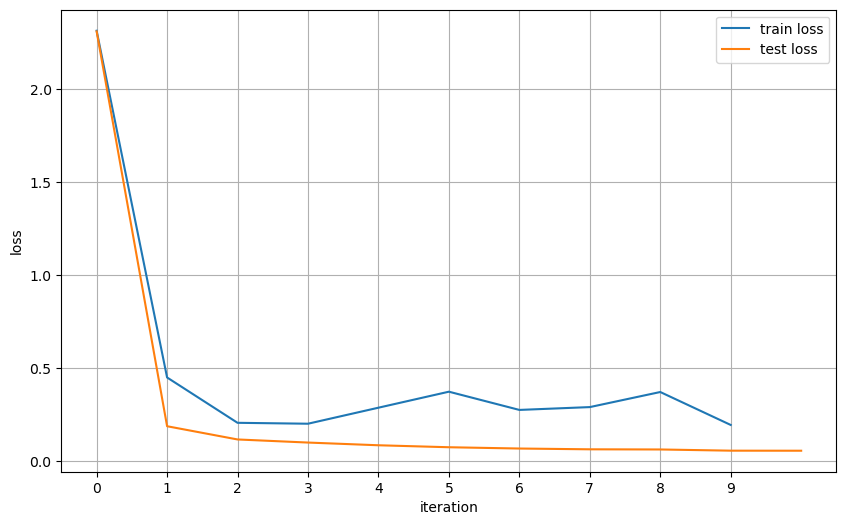

In [16]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(range(len(train_losses)),train_losses, label="train loss")
ax.plot(range(len(test_losses)),test_losses, label="test loss")
ax.set_xlabel("iteration")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))

ax.legend()
ax.grid()

## Take a look into model insight

Feature maps from conv1:


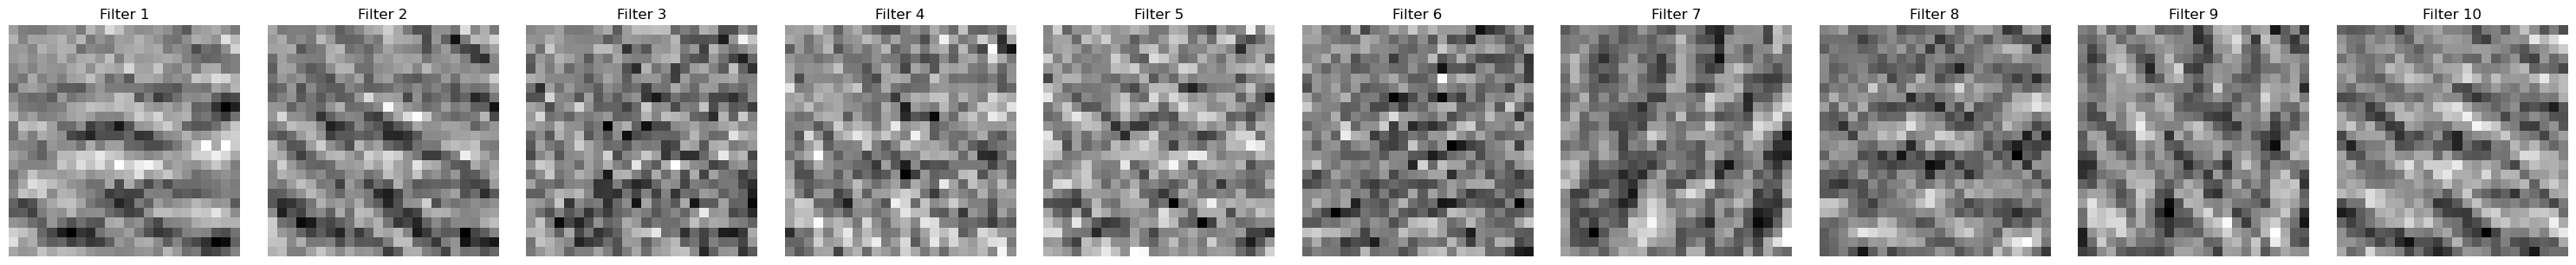

Feature maps from conv2:


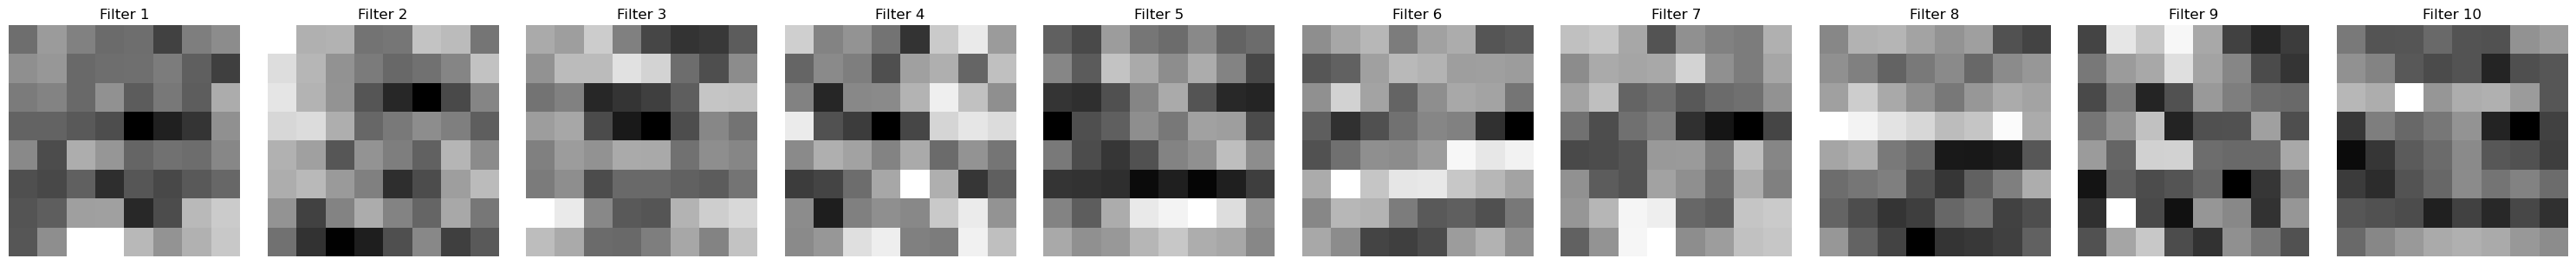

In [17]:
import torch
import matplotlib.pyplot as plt
from contextlib import contextmanager

# -------------------------------------------------
# Utility: forward hook context manager
# -------------------------------------------------
@contextmanager
def capture_feature_maps(model, layers):
    feature_maps = {}
    hooks = []

    def hook_fn(name):
        def _hook(module, input, output):
            feature_maps[name] = output.detach()
        return _hook

    for name, layer in layers.items():
        hooks.append(layer.register_forward_hook(hook_fn(name)))

    try:
        yield feature_maps
    finally:
        for hook in hooks:
            hook.remove()


# -------------------------------------------------
# Visualization function
# -------------------------------------------------
def visualize_feature_maps(feature_maps, layer_name, num_filters=5):
    fm = feature_maps[layer_name][0]  # first image in batch
    num_filters = min(num_filters, fm.size(0))

    fig, axes = plt.subplots(1, num_filters, figsize=(3 * num_filters, 3))
    if num_filters == 1:
        axes = [axes]

    for i in range(num_filters):
        axes[i].imshow(fm[i].cpu(), cmap="gray")
        axes[i].set_title(f"Filter {i + 1}")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()


# -------------------------------------------------
# Dummy input
# -------------------------------------------------
dummy_input = torch.randn(1, 1, 28, 28)

# -------------------------------------------------
# Capture and visualize feature maps
# -------------------------------------------------
layers_to_hook = {
    "conv1": network.conv1,
    "conv2": network.conv2,
}

with capture_feature_maps(network, layers_to_hook) as feature_maps:
    _ = network(dummy_input)

print("Feature maps from conv1:")
visualize_feature_maps(feature_maps, "conv1", num_filters=10)

print("Feature maps from conv2:")
visualize_feature_maps(feature_maps, "conv2", num_filters=10)

## Conceptual Interpretation of Feature Maps

Visualizing feature maps provides insight into how a convolutional neural network progressively transforms raw pixel data into meaningful representations.

### Early Convolutional Layers (e.g., `conv1`)
- Capture **low-level visual features** such as:
  - Edges and lines
  - Corners and simple curves
  - Basic texture patterns
- These layers act as **generic feature detectors**, responding strongly to local intensity changes in the image.

### Deeper Convolutional Layers (e.g., `conv2`)
- Build upon earlier features to detect **higher-level patterns**, including:
  - Combinations of edges (e.g., strokes or contours)
  - Shape-like structures
  - More abstract visual motifs
- Feature maps become increasingly **task-specific**, focusing on patterns relevant to classification.

### Why Feature Map Visualization Matters
- Helps verify that the network is learning meaningful representations
- Aids in debugging (e.g., detecting dead filters or poor activations)
- Improves interpretability by showing *where* and *how* the model responds to input data

Overall, feature maps illustrate the hierarchical nature of CNNs:  
**pixels → edges → shapes → semantic concepts**.

## Usage of trained model

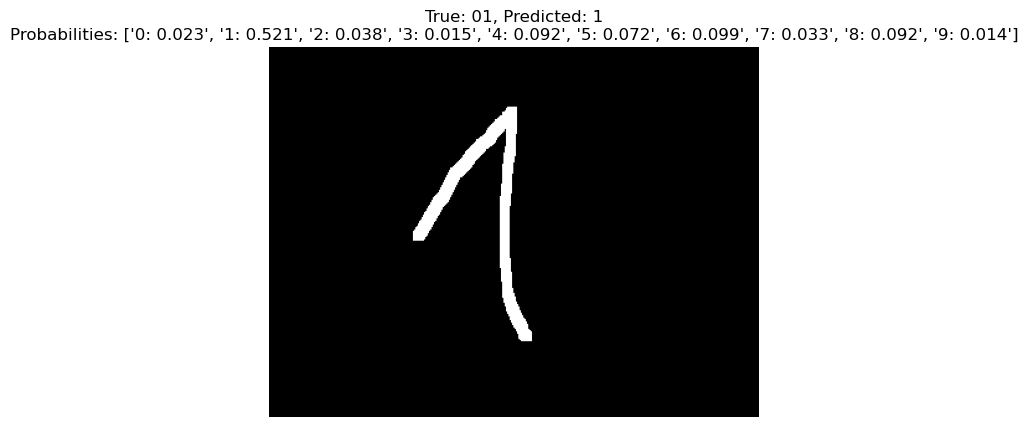

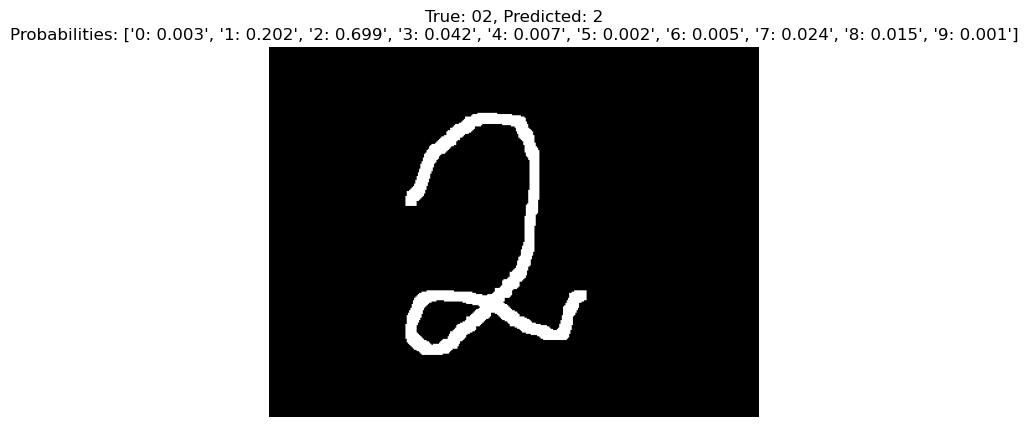

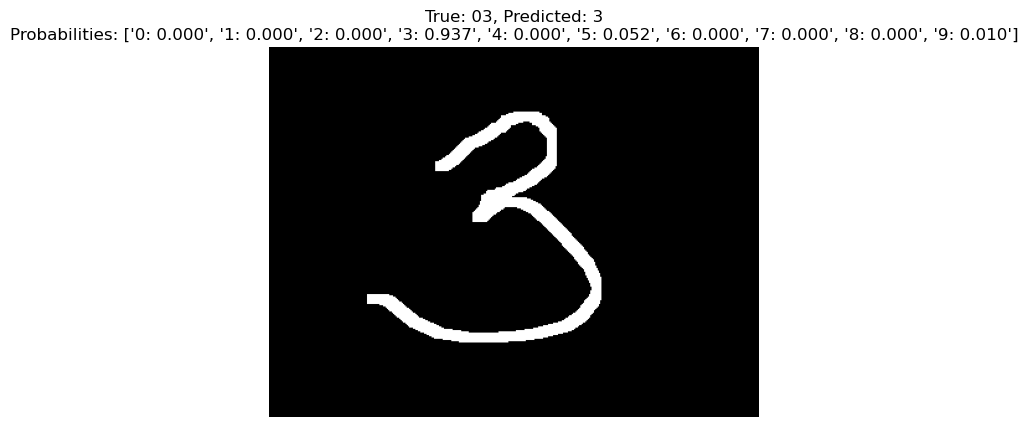

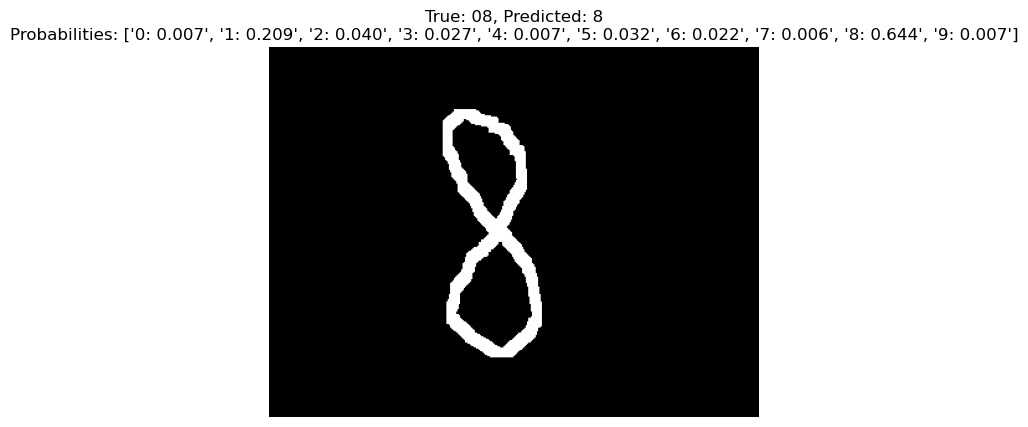

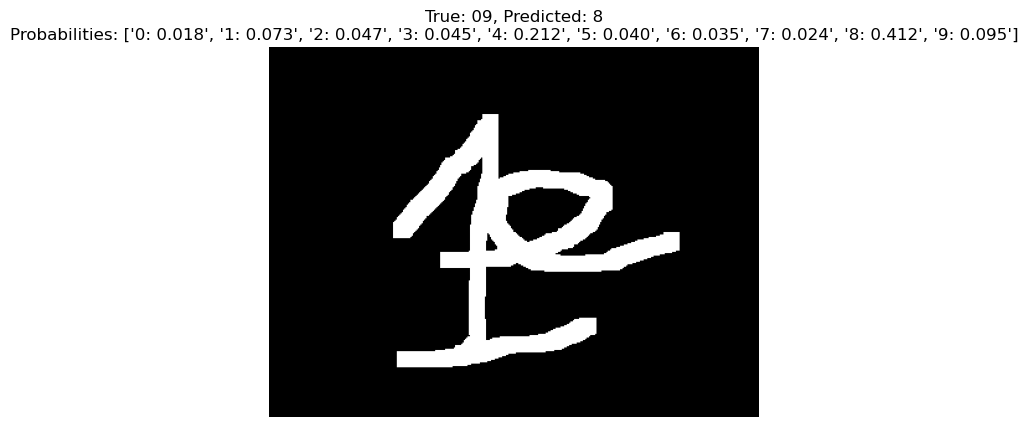

In [18]:
# Load the pre-trained model (make sure the path is correct)
model = MNISTNet()
model.load_state_dict(torch.load('model.pth'))
model.eval()  # Set to evaluation mode

# Preprocessing transform
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Ensure grayscale
    transforms.Resize((28, 28)),                  # Resize to 28x28
    transforms.ToTensor(),                        # Convert to tensor
    transforms.Normalize((0.1307,), (0.3081,))    # Normalize pixel values
])

def process_and_predict(image_path, model):
    """
    Process a PNG image, evaluate it with the model, and return the predicted digit and probabilities.
    """
    # Extract true label from filename (assuming filename format is `<label>.png`)
    true_label = os.path.basename(image_path).split('.')[0]

    # Load and preprocess the image
    img = Image.open(image_path)
    img_tensor = transform(img).unsqueeze(0)  # Add batch dimension

    # Evaluate using the model
    with torch.no_grad():
        output = model(img_tensor)
        probabilities = F.softmax(output, dim=1).squeeze().tolist()  # Convert logits to probabilities
        probabilities = [round(p, 3) for p in probabilities]
        predicted_label = output.argmax(dim=1).item()

    return img, true_label, predicted_label, probabilities


def evaluate_images_in_directory(directory, model):
    """
    Evaluate all images in a directory and display them with predictions.
    """
    for image_file in os.listdir(directory):
        if image_file.endswith(".png"):  # Process only PNG files
            image_path = os.path.join(directory, image_file)
            img, true_label, predicted_label, probabilities = process_and_predict(image_path, model)
            #formatted_probabilities = [f"{p:.3f}" for p in probabilities]  
            formatted_probabilities = [f"{i}: {p:.3f}" for i, p in enumerate(probabilities)]# Format to 3 decimal places

            # Display the image with the true label, prediction, and probabilities
            plt.imshow(img, cmap="gray")
            plt.title(f"True: {true_label}, Predicted: {predicted_label}\n"
                      f"Probabilities: {formatted_probabilities}")
            plt.axis("off")
            plt.show()

# Directory containing test PNG images
test_directory = "./mnist-handwritten"

# Evaluate all images in the directory
evaluate_images_in_directory(test_directory, model)
